<a href="https://colab.research.google.com/github/RaymundoDLC/MachineLearning/blob/main/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


  REPORTE DE CLASIFICACIÓN (RANDOM FOREST OPTIMIZADO)
               precision    recall  f1-score   support

No Pagado (0)       0.22      0.68      0.33       882
   Pagado (1)       0.91      0.57      0.70      5085

     accuracy                           0.59      5967
    macro avg       0.56      0.62      0.51      5967
 weighted avg       0.81      0.59      0.65      5967

Matriz de Confusión:
 [[ 598  284]
 [2183 2902]]

Recall de la Clase 'No Pagado' (0): 0.6780 (Objetivo de Negocio)
--------------------------------------------------
Área Bajo la Curva (AUC): 0.6708


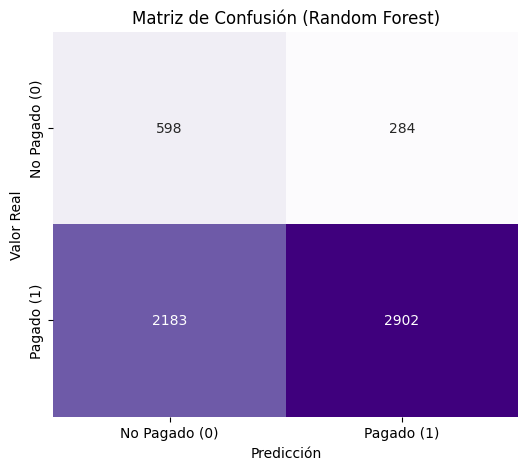

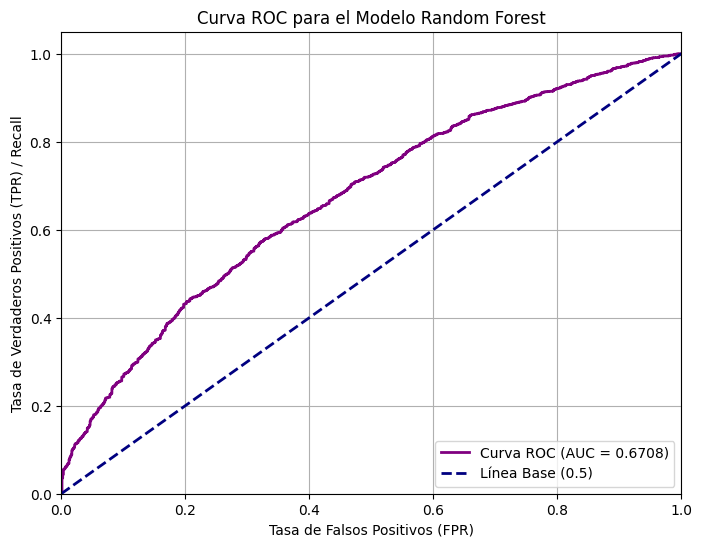

In [1]:
# ==============================================================================
# PROYECTO INTEGRADOR: MODELO RANDOM FOREST (BOSQUE ALEATORIO)
# ==============================================================================

# --- 1. CONFIGURACIÓN E IMPORTACIONES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier # Modelo clave
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    roc_curve,
    roc_auc_score
)

# Configuración de visualización
pd.set_option('display.max_columns', None)

# --- 2. CARGA Y PREPROCESAMIENTO DE DATOS (REUSO DE LA PARTE 1) ---

# *NOTA: Asumimos que el archivo .csv ha sido subido.*
try:
    df = pd.read_csv('lending_club_2007_2011_6_states (1).csv')
except FileNotFoundError:
    print("Error: Asegúrate de subir el archivo CSV al entorno de Colab.")
    exit()

# 2.1 Limpieza y creación de la variable objetivo
df['repaid'] = df['loan_status'].apply(lambda status: 1 if status in ['Fully Paid'] else 0)

# 2.2 Selección, limpieza y Codificación
feature_cols = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc',
    'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
    'purpose', 'grade', 'home_ownership', 'verification_status'
]
df_clean = df[df.columns.intersection(feature_cols + ['repaid'])].copy()
df_clean.dropna(inplace=True)

# Codificación One-Hot
df_dummies = pd.get_dummies(df_clean, columns=['purpose', 'home_ownership', 'verification_status'], drop_first=True)

# Codificación Ordinal de 'grade'
grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
df_dummies['grade_code'] = df_dummies['grade'].map(grade_mapping)
df_dummies.drop('grade', axis=1, inplace=True)

# Definición final de X e Y
X = df_dummies.drop('repaid', axis=1)
y = df_dummies['repaid']

# 2.3 División y Escalamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
scaler = StandardScaler()
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()

# NOTA: Random Forest no requiere escalamiento, pero usamos los datos escalados
# para mantener la coherencia con la preparación general del proyecto.
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])


# --- 3. ENTRENAMIENTO DEL MODELO RANDOM FOREST (PARTE 2) ---

# Se utilizan los hiperparámetros óptimos encontrados en el notebook 'RandomForest.ipynb'
# y se añade class_weight='balanced' para enfocarse en la clase minoritaria (0: No Pagado).
rf_model = RandomForestClassifier(
    n_estimators=100,             # Número de árboles
    max_depth=5,                  # Profundidad máxima (para evitar sobreajuste)
    min_samples_split=5,          # Mínimo de muestras para dividir
    min_samples_leaf=1,           # Mínimo de muestras por hoja
    max_features='sqrt',          # Número de características a considerar en cada división
    class_weight='balanced',      # Ajuste para el desbalance de clases
    random_state=42,
    n_jobs=-1                     # Usar todos los núcleos del procesador
)

rf_model.fit(X_train_scaled, y_train)

# Predicción de CLASES
y_pred = rf_model.predict(X_test_scaled)

# Predicción de PROBABILIDADES
y_proba = rf_model.predict_proba(X_test_scaled)[:, 1] # Probabilidad de la Clase 1 (Pagado)


# --- 4. EVALUACIÓN Y GRÁFICOS (PARTE 3) ---

print("\n" + "="*50)
print("  REPORTE DE CLASIFICACIÓN (RANDOM FOREST OPTIMIZADO)")
print("="*50)

# 4.1 Reporte de Clasificación y Matriz de Confusión
print(classification_report(y_test, y_pred, target_names=['No Pagado (0)', 'Pagado (1)']))
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:\n", cm)

# Métrica de Negocio Clave
recall_clase_0 = recall_score(y_test, y_pred, pos_label=0)
print(f"\nRecall de la Clase 'No Pagado' (0): {recall_clase_0:.4f} (Objetivo de Negocio)")
print("-" * 50)

# 4.2 Métricas ROC y AUC
auc_score = roc_auc_score(y_test, y_proba)
print(f"Área Bajo la Curva (AUC): {auc_score:.4f}")

# 4.3 Gráfico de la Matriz de Confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=['No Pagado (0)', 'Pagado (1)'],
            yticklabels=['No Pagado (0)', 'Pagado (1)'])
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión (Random Forest)')
plt.show()

# 4.4 Generación del Gráfico de Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'Curva ROC (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Línea Base (0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR) / Recall')
plt.title('Curva ROC para el Modelo Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()